In [2]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import xarray as xr
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import time

from analysisTools import *

In [7]:
temperature_y = xr.open_dataset("data/data808/temperature_y_300_cos.nc")
temperature_y=temperature_y.temperature_real+1j*temperature_y.temperature_imag

In [8]:
temperature_y_150_NH = np.array(temperature_y)[:,:,150:]

# Power spectrum with negative m

1.0644560090691416e-05 9.446961287184824e-06
4.132080896866172e-05 3.202457238364103e-05


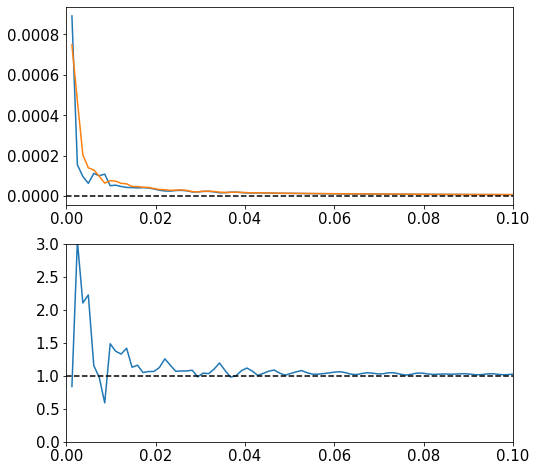

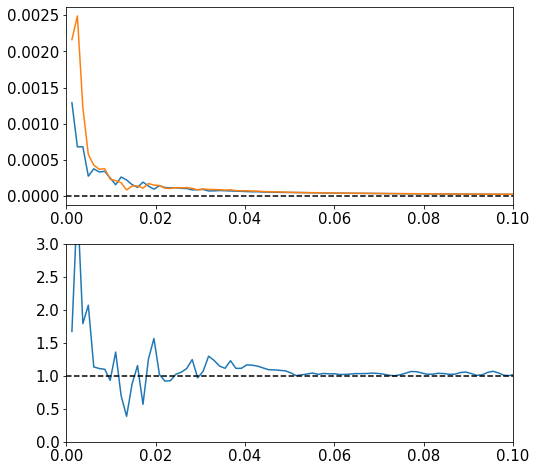

In [9]:
def set_y(ngrid):
    """Sets a y (=cos(latitude)) grid from 0 to 1, nonlinearly spaced, with ngrid points"""
    return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the right bound to avoid divisions by 0

def plot_spectrum_source(temp,alllats=True,latidx=0):    
    # adapts chi
    temp=np.fft.ifft(temp,axis=0)[1:]
    nt,_,ngrid=temp.shape
    y=set_y(ngrid)
    
    fig,(ax,ax2)=plt.subplots(2,1,figsize=(8,8))
    
    freqs = nonzero_frequencies() # all frequencies in years^-1
    if alllats:
        temp_yravg = np.trapz(temp.mean(axis=1)*y/np.sqrt(1-y**2),y,axis=1)
    else:
        temp_yravg = temp[:,:,latidx].mean(axis=(1))
    permut = np.roll(np.arange(nt),(nt+1)//2)
    
    ax.plot(freqs[:nt//2],np.abs(temp_yravg)[:nt//2])
    ax.plot(-freqs[nt//2:],np.abs(temp_yravg)[nt//2:])
    print(np.abs(temp_yravg)[nt//2:].mean(),np.abs(temp_yravg)[:nt//2].mean())
    ax.set_xlim(0.,0.1)
    ax.axhline(0.,color='k',linestyle='--')
    
    ax2.plot(freqs[:nt//2],np.abs(temp_yravg)[nt//2+1:][::-1]/np.abs(temp_yravg)[:nt//2])
    ax2.set_xlim(0.,0.1)
    ax2.set_ylim(0.,3.)
    ax2.axhline(1.,color='k',linestyle='--')


plot_spectrum_source(temperature_y_150_NH)
plot_spectrum_source(temperature_y_150_NH,False,-5)

## Hovmoeller

In [75]:
phis=np.linspace(0,2*np.pi,50)
temperature_tphi = np.real(temperature_y_150_NH[:,:,-20:].mean(axis=(1,2))[:,None]*np.exp(3*1j*phis)[None,:])
temperature_tphi_plot=xr.DataArray(temperature_tphi,coords={'time':np.array(ntsteps_to_years(temperature_y1.t_step-temperature_y1.t_step[0])),'phi':phis*180/np.pi},dims={'time','phi'})


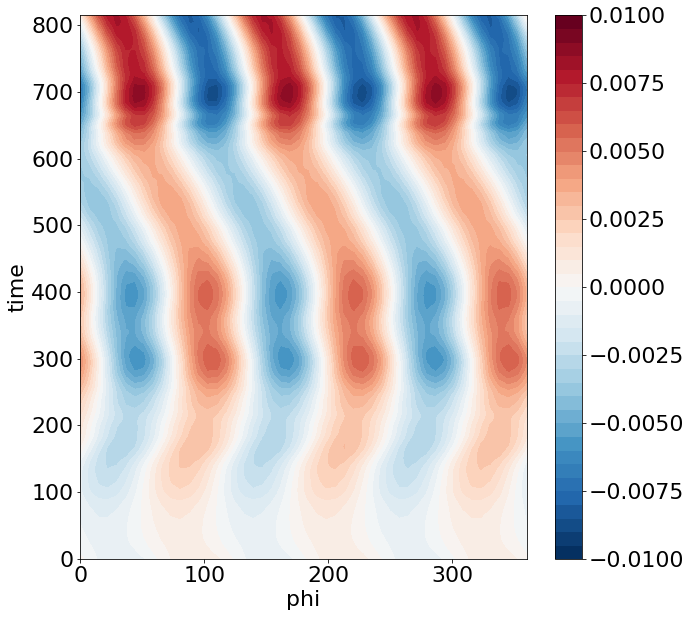

In [76]:
# Visualize a radius/time plot using xarray's plotting shortcuts

fig,ax=plt.subplots(1,1,figsize=(10,10))
temperature_tphi_plot.plot.contourf(ax=ax,y='time',levels=np.linspace(-.01,.01,41))#,cmap=plt.cm.RdBu_r)


## Lorentz Force

In [79]:
Lorentz_y1 = xr.open_dataset("data/data808/Lorentz_force_y_300_cos.nc")
Lorentz_y2 = xr.open_dataset("data/data808/Lorentz_force_y_mm3_300_cos.nc")
Lorentz_y_r     = Lorentz_y1.Lorentz_force_r_real+1j*Lorentz_y2.Lorentz_force_r_imag
Lorentz_y_theta = Lorentz_y1.Lorentz_force_theta_real+1j*Lorentz_y2.Lorentz_force_theta_imag
Lorentz_y_phi   = Lorentz_y1.Lorentz_force_phi_real+1j*Lorentz_y2.Lorentz_force_phi_imag

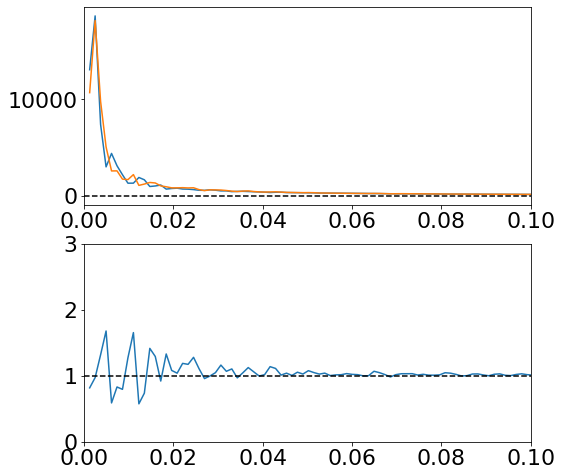

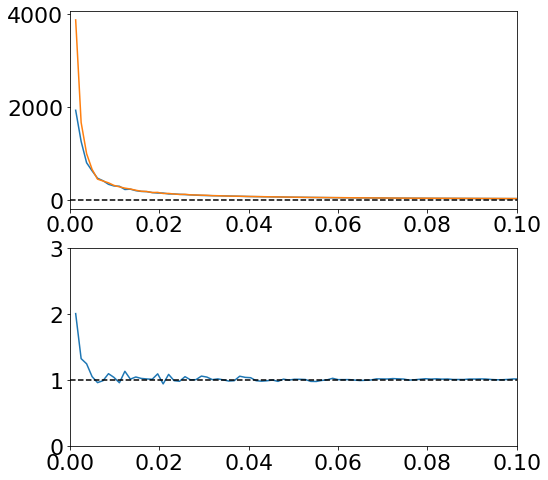

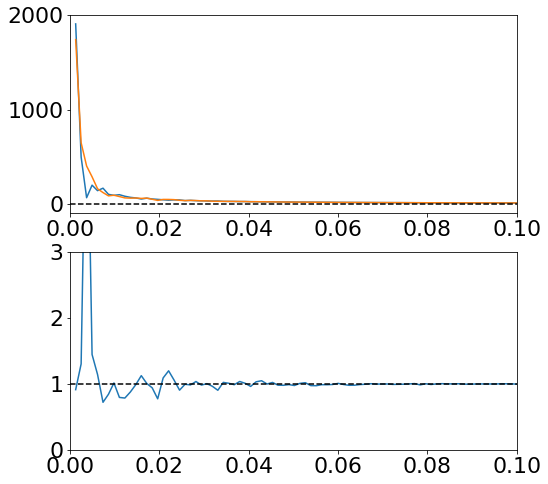

In [80]:
plot_spectrum_source(Lorentz_y_r     )
plot_spectrum_source(Lorentz_y_theta )
plot_spectrum_source(Lorentz_y_phi   )

In [101]:
phis=np.linspace(0,2*np.pi,50)
Lorentz_y_theta_150_NH = np.array(Lorentz_y_theta)[:,:,150:]
Lorentz_theta_tphi = np.real(Lorentz_y_theta_150_NH[:,:,0:40].mean(axis=(1,2))[:,None]*np.exp(3*1j*phis)[None,:])
Lorentz_theta_tphi_plot=xr.DataArray(Lorentz_theta_tphi,coords={'time':np.array(ntsteps_to_years(temperature_y1.t_step-temperature_y1.t_step[0])),'phi':phis*180/np.pi},dims={'time','phi'})


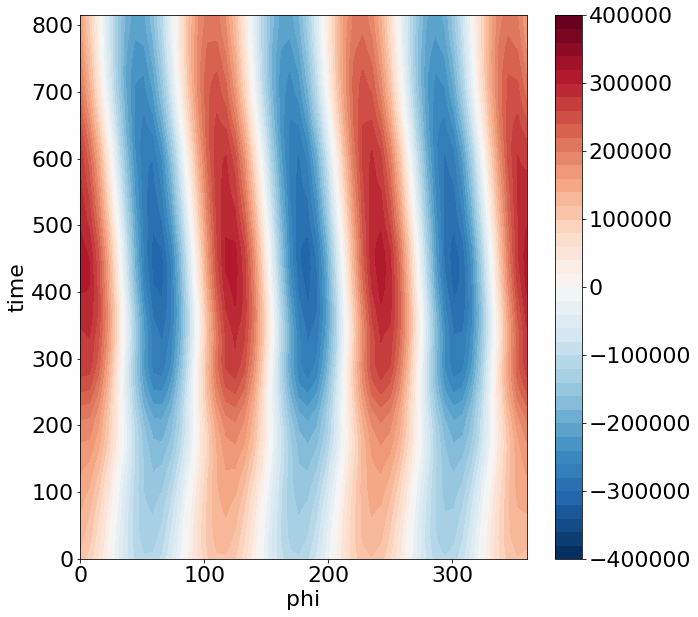

In [102]:
# Visualize a radius/time plot using xarray's plotting shortcuts

fig,ax=plt.subplots(1,1,figsize=(10,10))
Lorentz_theta_tphi_plot.plot.contourf(ax=ax,y='time',levels=np.linspace(-4e5,4e5,41))#,cmap=plt.cm.RdBu_r)


In [9]:
m=3
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400

# use realistic values
E = 1e-15
Pm = 4.7e-7
Rastar = 8e-5   # From "stochastic generation" (earth-like value)

Hprime=0.062 #Nondimensional layer thickness #0.11 to match simulation
Nprime = 0.583 #0.14/E From "stochastic generation"
Brprime = 3e-5 #np.sqrt(float(layered_s.M_ene_pol.sel(radial_id=310).mean())*2)

fixedparams=(E,Pm,Rastar,Hprime,Nprime,Brprime)

# Thermal source

In [82]:
# Fourier transform the forcing
temperature_y_layer_tilda_300=transform_forcing(temperature_y,'sin')
# Pick Northern Hemisphere
temperature_y_layer_tilda_150_NH=temperature_y_layer_tilda_300[:,:,150:]
temperature_y_layer_tilda_150_SH=temperature_y_layer_tilda_300[:,:,149::-1]
# Convert magnitude to diffusion-free scales
temperature_y_layer_tilda_150_NH *= 1
temperature_y_layer_tilda_150_SH *= 1

## Response to a fixed frequency

Here we compute, for a given mode $m,j,\omega$ (with $j=1,2,3$ and $\omega=2\pi/(-20 \mathrm{ years})$), the wave solution as a zonal magnetic perturbation $\tilde b_y(y)$. In order to relate this to a velocity perturbation, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_y) = -i\omega\chi \tilde b_y$$
If the velocity perturbation is zero at the base of the layer (or below a small skin depth), and if we denote by $k$ the radial wavenumber ($k = j\pi/H$, such that the radial structure of $b_y$ is given by $\sin(kz)$), then $$\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$$
where the radial structure of $v_y$ is now a $\cos(kz)$. When all these quantities are nondimensional, we convert back to dimensional terms by multipliying by $\Omega L$.

One can then sum over all radial wavenumbers $j$ to obtain the wave response to the full $m=3, \omega=2\pi/(-20 \mathrm{ years})$ component of the forcing. In order to get its rms value integrated in radius, Parseval's theorem for half range Fourier series reads (if $\tilde b_y''(y,z) = \sum_k \tilde b_{yk}''(y) \sin(kz)$):
$$\dfrac{1}{H}\int_0^H \Re(\tilde b_y''(y,z))^2\mathrm{d}z = \dfrac{1}{2}\sum_k \Re(\tilde b_{yk}''(y))^2$$

We then average this RMS values between contribution from the Northern and Southern hemispheres.

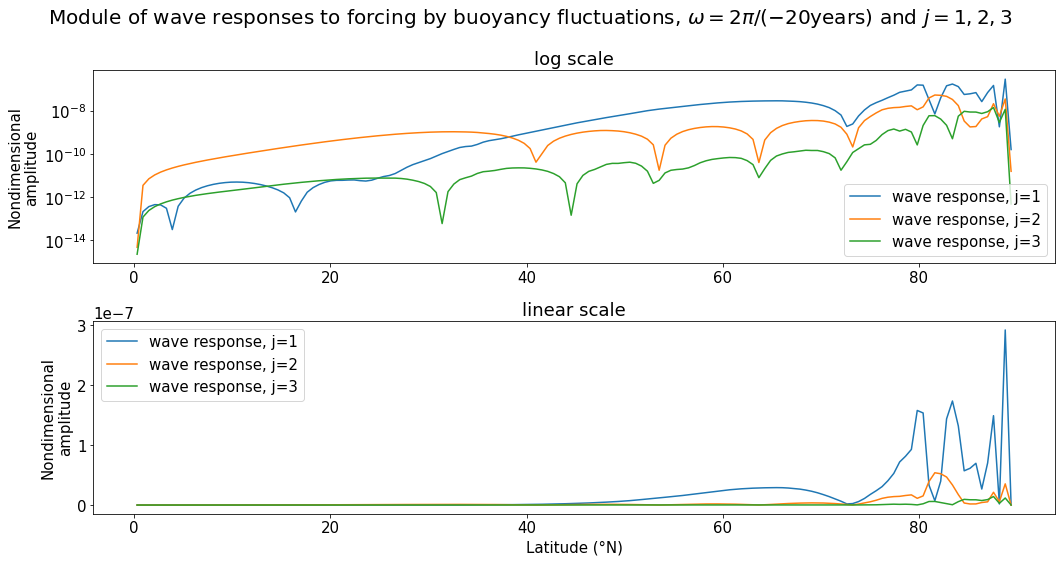

In [11]:
fig,ax=plt.subplots(2,1,figsize=(15,8))
y=set_y(150)
for j in range(1,4):
    freqindex=period_to_freqindex(-20)
    by=set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,freqindex,j,fixedparams)
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i'%j)
    ax[1].plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 1:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('log scale')
ax[1].set_title('linear scale')
ax[1].set_xlabel('Latitude (°N)')
ax[0].set_ylabel('Nondimensional\namplitude')
ax[1].set_ylabel('Nondimensional\namplitude')

fig.suptitle(r"Module of wave responses to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$ and $j=1,2,3$ ",fontsize=20)
fig.tight_layout()

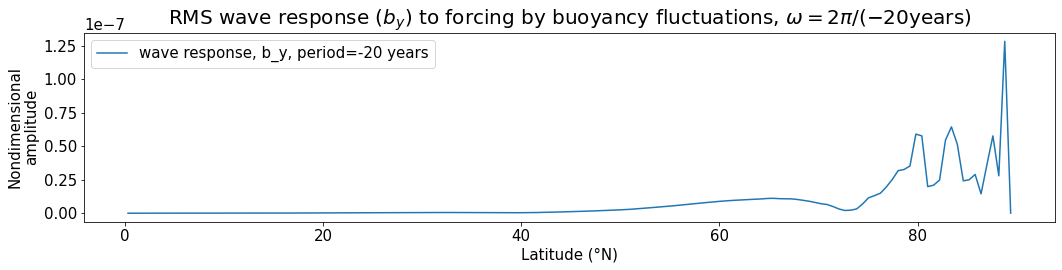

In [17]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
y=set_y(150)
by_all_NH=[]
by_all_SH=[]
for j in range(1,10):
    freqindex=period_to_freqindex(-20)
    by_all_NH.append(set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,freqindex,j,fixedparams))
    by_all_SH.append(set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,freqindex,j,fixedparams))

by_rms=0.5*(np.sqrt(0.5*(np.real(np.array(by_all_NH))**2).sum(axis=0))+np.sqrt(0.5*(np.real(np.array(by_all_SH))**2).sum(axis=0)))

ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,label='wave response, b_y, period=-20 years')
    
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

In [28]:
L = 3.48e6*0.65
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400
velocity_scale = Omega*L

kprime = np.pi/Hprime
omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
chi = 1 +1j*kprime**2/omegaprime*E/Pm
js=np.arange(1,57)
ks = kprime*js[:,None]
b_to_v_factor = -1j*omegaprime*chi/Brprime/ks


vy_rms=0.5*(np.sqrt(0.5*(np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH))**2).sum(axis=0))+np.sqrt(0.5*(np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH))**2).sum(axis=0)))


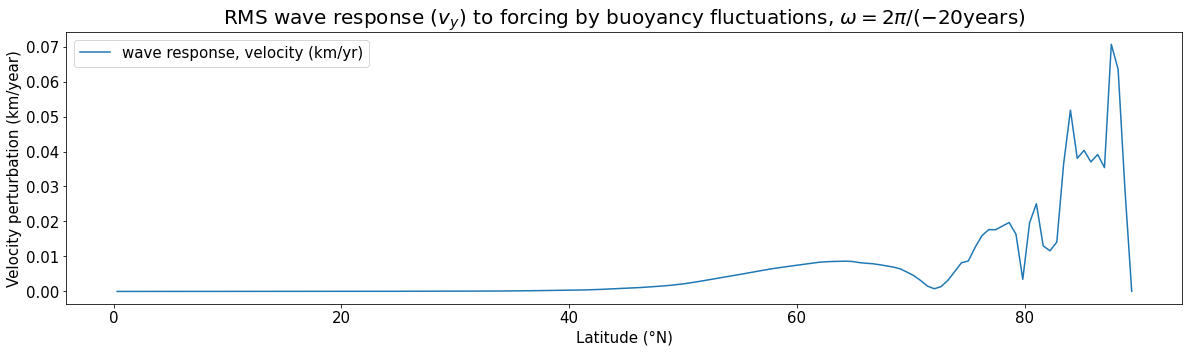

In [29]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label='wave response, velocity (km/yr)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Velocity perturbation (km/year)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

## Power spectrum

Here, we pick the eigenmodes of the unforced problem and express the power distribution of the response to a forcing projected on a specific mode.
e.g., let's say the modes of our problem $Ax - \omega x = 0$ are $(x_n)_{1\leq n \leq N}$. We pick one $n$, identified by its period (related to its eigenvalue $\omega_n$ by $T_n = 2\pi/\omega_n$). We write the forcing (or rather its partial fourier transform) as $F(\omega,y)$, and express it as $F(\omega,y)=\sum_n c_n(\omega) x_n(y)$.

Then, denoting $x(\omega,y)$ the response to the forced problem $Ax(\omega,y) - \omega x(\omega,y) = F(\omega,y)$, one can show $x(\omega,y)=\sum_n \dfrac{c_n(\omega)}{\omega_n-\omega} x_n(y)$. We plot below, for various $n$, the function $\omega \mapsto \left|\dfrac{c_n(\omega)}{\omega_n-\omega}\right|^2$.

One caveat in all this is that $A$ itself depends on $\omega$, through the damping factor $\chi$. We will ignore this dependence by setting $\chi$ as for $\omega = - 2\pi/\text{20 years}$.

240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269

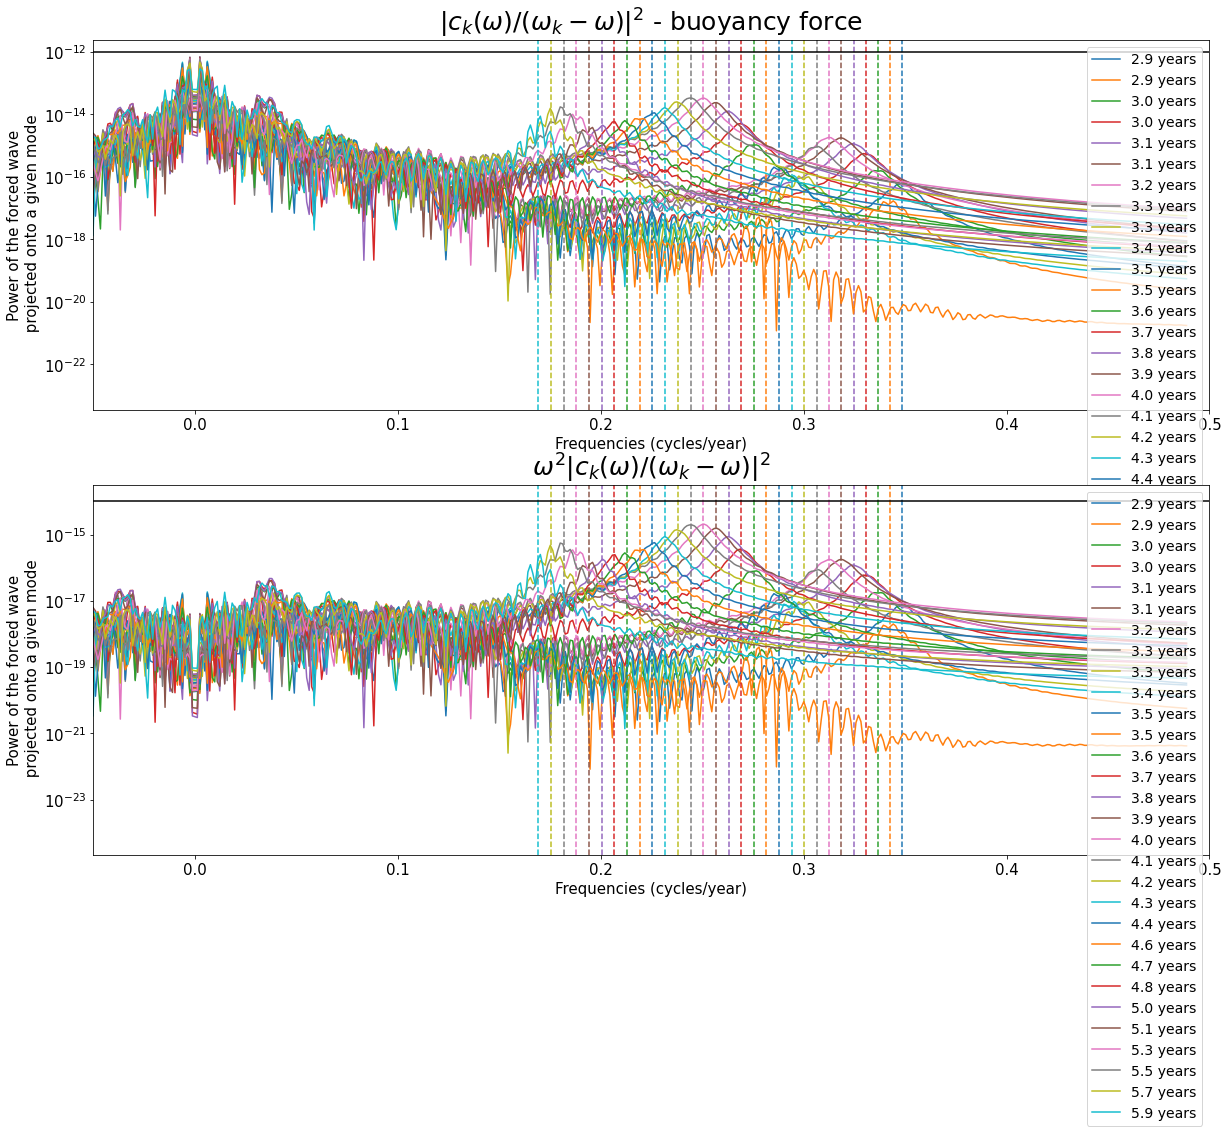

In [45]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,15))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(240,270):
    print(i,end='')
    frequencies,power_spectrum,period=spectrum_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,i,1,fixedparams,npoints=7)
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax2.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    ax2.axvline(1/period,color=colors[i%10],linestyle='--')


for a in ax,ax2:
    a.set_xlim(-0.05,0.5) 
    a.legend(fontsize=14)
    a.set_xlabel('Frequencies (cycles/year)')
    a.set_ylabel('Power of the forced wave\n projected onto a given mode')
    a.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - buoyancy force',fontsize=25)
ax2.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)
ax.axhline(1e-12,color='k')
ax2.axhline(1e-14,color='k')   

## Amplitude of the acceleration

Here, we compute the root mean square acceleration of the waves forced by buoyancy. For each frequency $\omega$ and $k$, we solve for the forced wave in terms of a magnetic perturbation $\tilde b_y(\omega,k,y)$. We transform it into a velocity perturbation, as above, with $\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$, then into an acceleration as $\tilde a_y = \omega \tilde v_y$. Finally the RMS amplitude is 

$$A_y(y) = \sqrt{\int \dfrac{1}{2}\sum_k |\tilde a_{y}(\omega,k,y)|^2 \mathrm{d} \omega}$$

In discretized terms, the temporal fourier transform has been defined such that $b_y(t_n) = \sum_{m=0}^{N-1} \tilde b_y(\omega_m) e^{-2\pi i \omega_m t_n}$ with $n = 0 \dots N-1$.

There, Parseval's equality reads : $$\frac{1}{N}\sum_{n=0}^{N-1} |b_y(t_n)|^2 = \sum_{m=0}^{N-1} |\tilde b_y(\omega_m)|^2$$

In [237]:
%%time
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=2; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH_b1=np.zeros((Nf,Nr,150))*1j
by_all_SH_b1=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH_b1[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,f,j,fixedparams)
        by_all_SH_b1[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,f,j,fixedparams)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 45.3 s, sys: 895 ms, total: 46.2 s
Wall time: 29.4 s


In [238]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_b1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_b1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0#350
sl2=800#400
vy_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


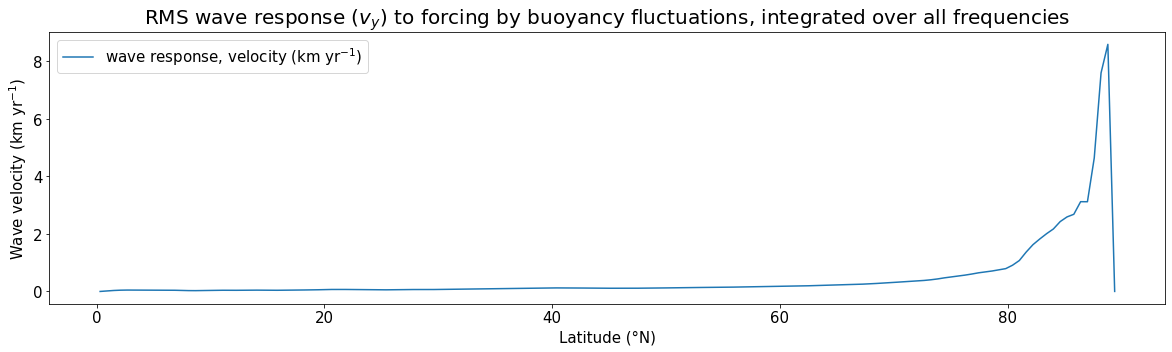

In [239]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_b1/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

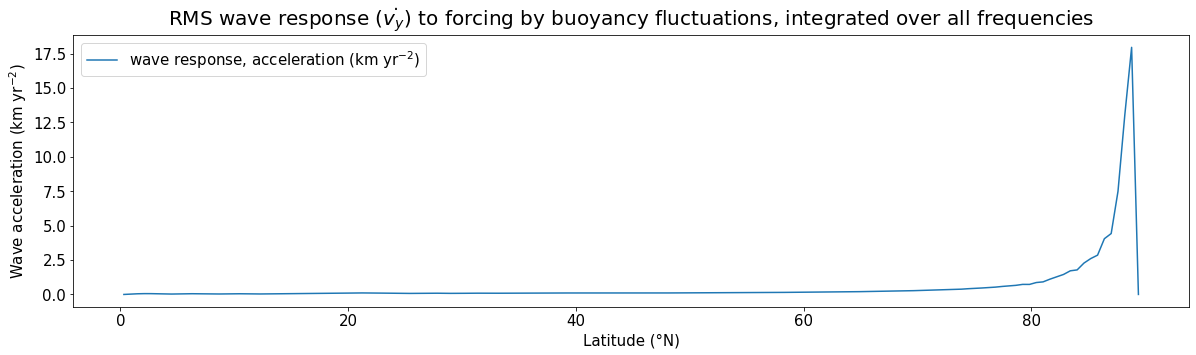

In [240]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_b1/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

In [242]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_b1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_b1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           )


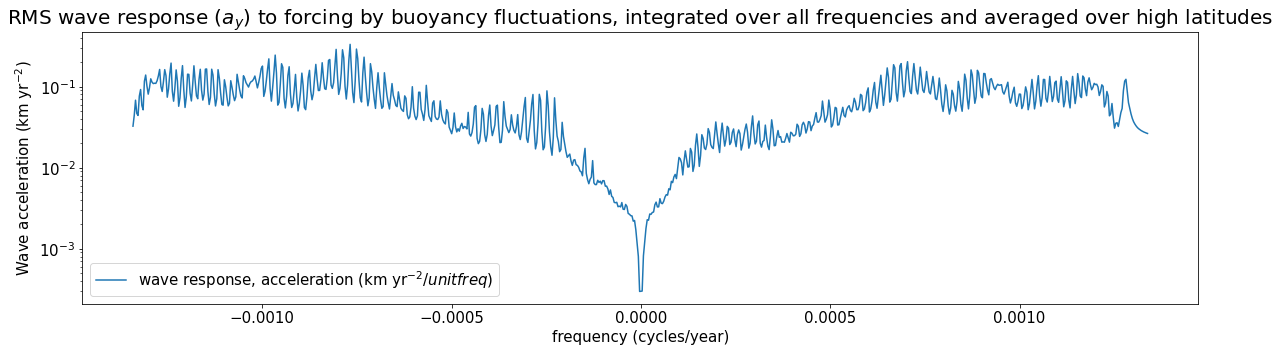

In [243]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(omegas_nondim.reshape(-1),ay_rms_b1/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Amplitude, projected on eigenmodes

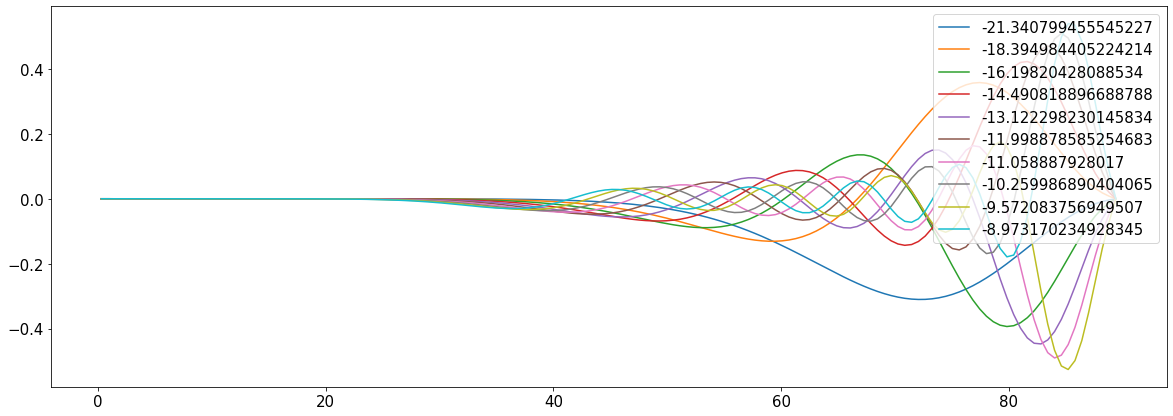

In [189]:
# Plotting the eigenmodes
def plot_eigenmodes(n):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    _,ax=plt.subplots(1,1,figsize=(20,7))
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label=eigenmode_period)

    ax.legend()
plot_eigenmodes(10)

CPU times: user 12.9 ms, sys: 1.16 ms, total: 14.1 ms
Wall time: 10.1 ms
CPU times: user 317 ms, sys: 9.86 ms, total: 327 ms
Wall time: 381 ms


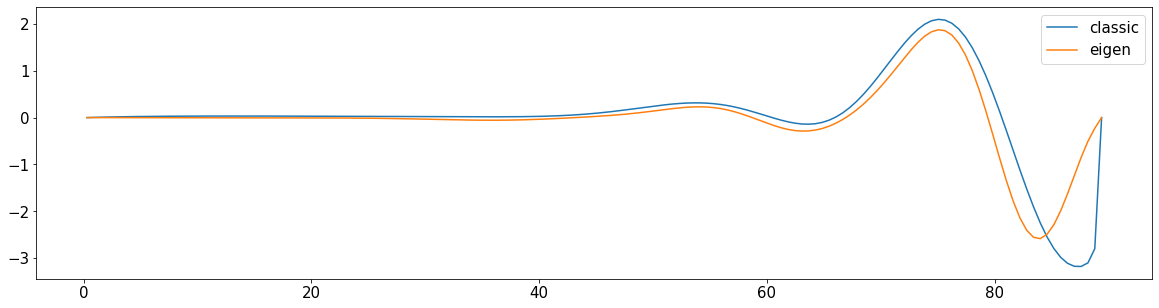

In [228]:
def solve_1(fixedparams):
    ngrid=150
    y = set_y(ngrid)
    
    period = -20
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    A = set_A(ngrid,m,M)
    return solve_forced_problem(y,A,C,np.ones(ngrid*2))

def solve_2(fixedparams):
    ngrid=150
    y = set_y(ngrid)
    
    period = -20
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    A = set_A(ngrid,m,M)
    
    nmodes=10 #Take the n first modes by order of increasing period
    
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    order=np.argpartition(np.real(1/wi),nmodes)
    xi=xi[:,order]
    zi=zi[:,order]
    wi=wi[order]
    rhs=np.ones(ngrid*2)
    return np.sum(np.dot(zi[:,:nmodes].conj().T,rhs)/(wi[:nmodes]-C) * xi[:,:nmodes],axis=1)[:ngrid]/(1-y**2)


_,ax=plt.subplots(1,1,figsize=(20,5))
%time ax.plot(np.arcsin(y)*180.0/np.pi,np.real(solve_1(fixedparams)),label='classic')
%time ax.plot(np.arcsin(y)*180.0/np.pi,np.real(solve_2(fixedparams)),label='eigen')
ax.legend()


In [64]:
%%time
sectoyear = 365.25 * 24 * 60 * 60
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=1; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH=np.zeros((Nf,Nr,150))*1j
by_all_SH=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,f,j,fixedparams,limitmodes=40)
        by_all_SH[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,f,j,fixedparams,limitmodes=40)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 6min 53s, sys: 5.46 s, total: 6min 58s
Wall time: 4min


In [65]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0#350
sl2=800#400
vy_rms=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


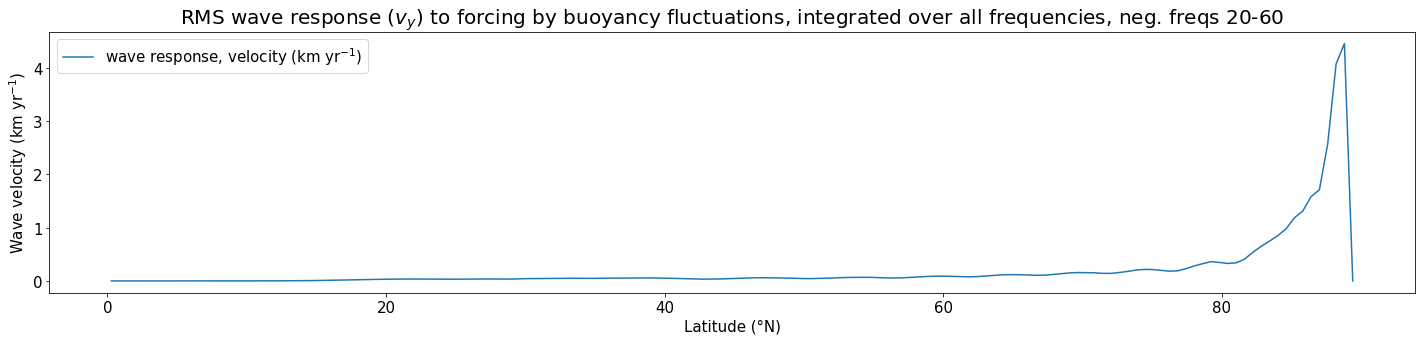

In [66]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, neg. freqs 20-60",fontsize=20)
fig.tight_layout()

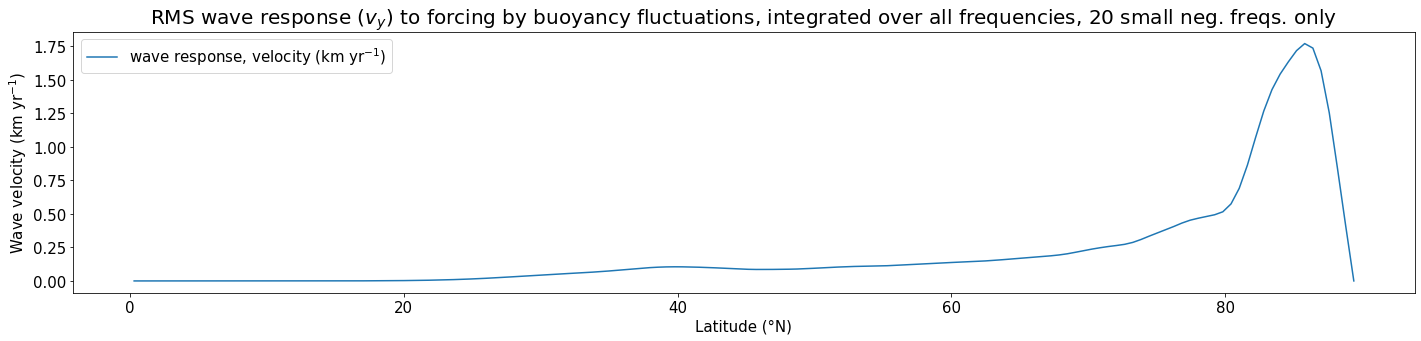

In [61]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, 20 small neg. freqs. only",fontsize=20)
fig.tight_layout()

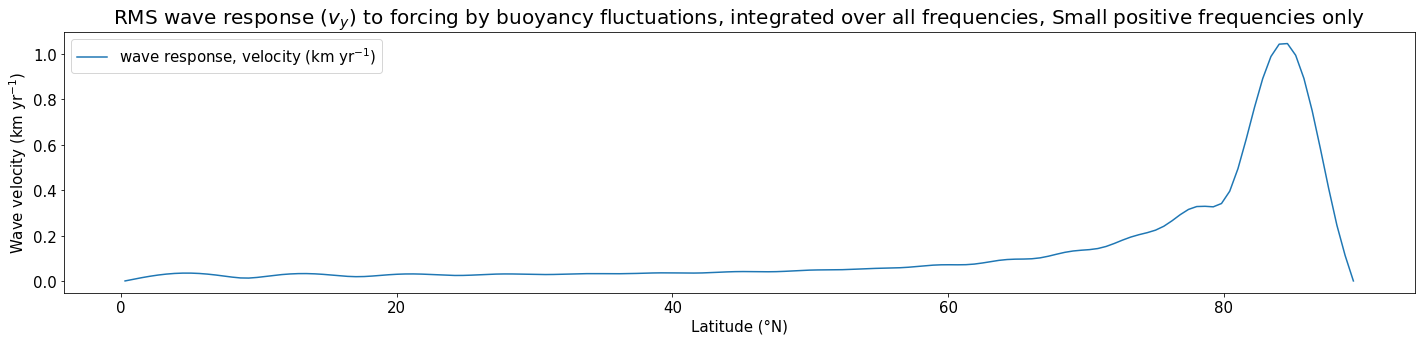

In [56]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, Small positive frequencies only",fontsize=20)
fig.tight_layout()

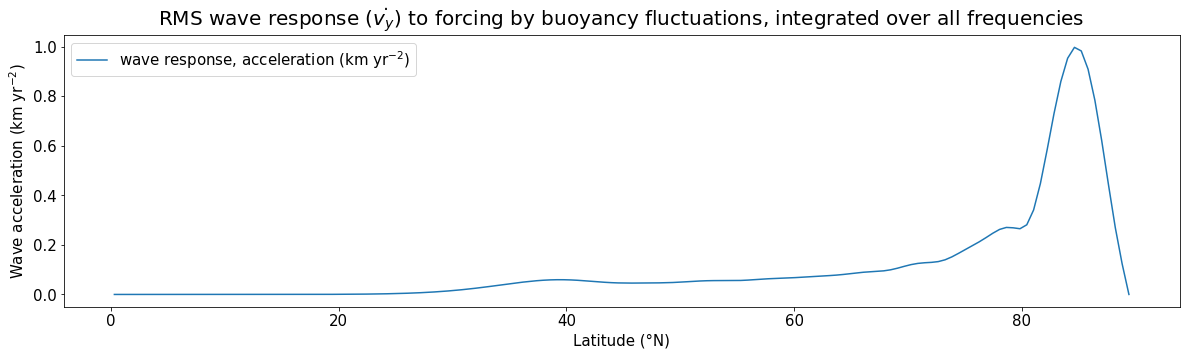

In [234]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

In [235]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           )


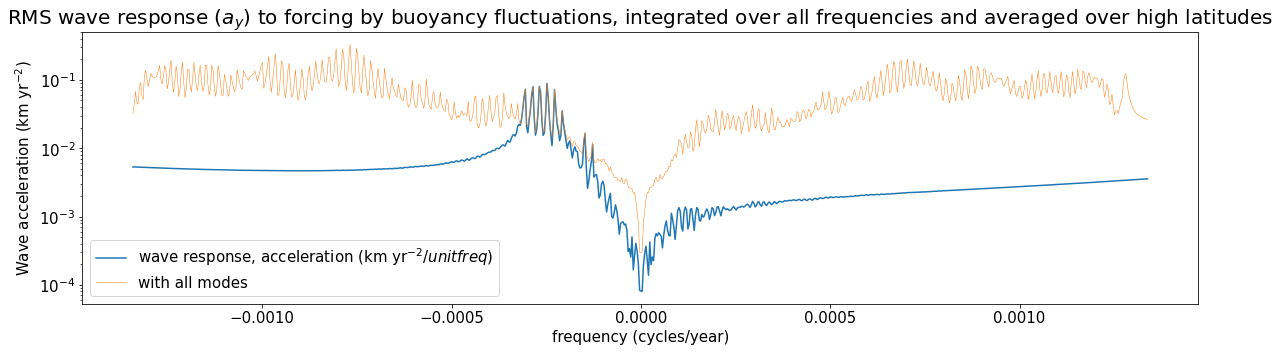

In [246]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(omegas_nondim.reshape(-1),ay_rms/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.plot(omegas_nondim.reshape(-1),ay_rms_b1/1e3*sectoyear**2,label=r'with all modes',linewidth=0.5)
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')